In [5]:
import numpy as np

from sklearn.linear_model import SGDClassifier, LinearRegression, Lasso, Ridge
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
import seaborn as sn
import random
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from sklearn.manifold import TSNE
import tqdm
import copy
from sklearn.svm import LinearSVC 

from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import TruncatedSVD
import torch
from sklearn.linear_model import SGDClassifier

import sys
sys.path.append("MKLpy")

import inlp, inlp_dataset_handler, inlp_linear_model
from pytorch_revgrad import RevGrad
from sklearn.svm import LinearSVC

import sklearn
from sklearn.linear_model import LogisticRegression
import random
import pickle
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn import neural_network
#from gensim.modenp.isnanls.keyedvectors import Word2VecKeyedVectors
#from gensim.models import KeyedVectors
from relaxed_inlp import solve_fantope_relaxation,solve_fantope_relaxation_fr
from sklearn.svm import SVC
import scipy
import os
from MKLpy.metrics import pairwise
from MKLpy.algorithms import AverageMKL, EasyMKL, KOMD
import torch.nn.functional as F
import sys

MODE = "glove"
ALPHA = 0.01
TOL = 1e-4
ITER_NO_CHANGE = 900
LOSS = "log"
from run_kernels import load_glove

/home/nlp/ravfogs/anaconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## report pipelines accuracies

In [7]:
post_proj_accuracies = []
preimage_erros = []
params2preimage = dict()

for run_id in [10, 11, 12, 13]:
    for filename in os.listdir("./interim/glove{}/kernel/preimage".format(run_id)):
        
        if not filename.endswith(".pickle"): continue
        if not "Z." in filename: continue
            
        params_str = (filename.rsplit('.', 1)[0]).split('.', 1)[1]
        params_dict = {kv.split("=")[0]:kv.split("=")[1] for kv in params_str.split("_")}
        
        with open("./interim/glove{}/kernel/preimage/Z_dev.{}.pickle".format(run_id, params_str), "rb") as f:
            Z_dev,error, mean_norm_normalized, post_proj_acc = pickle.load(f)
            post_proj_accuracies.append(post_proj_acc)
            preimage_erros.append(error/mean_norm_normalized)
        
        s = "_".join(["=".join([k,v]) for k,v in params_dict.items()])
        params2preimage[s]=error/mean_norm_normalized
        
with open("preimage-errors.dict.pickle", "wb") as f:
    pickle.dump(params2preimage, f)

In [8]:
scipy.stats.pearsonr(post_proj_accuracies,preimage_erros)

PearsonRResult(statistic=0.11857693679621704, pvalue=0.1825012820393873)

In [9]:
def perform_purity_test(vecs, k, labels_true):
        np.random.seed(0)
        clustering = sklearn.cluster.KMeans(n_clusters = k)
        clustering.fit(vecs)
        labels_pred = clustering.labels_
        score = sklearn.metrics.homogeneity_score(labels_true, labels_pred)
        return score

def compute_v_measure(vecs, labels_true, k=2):
    
        np.random.seed(0)
        clustering = sklearn.cluster.KMeans(n_clusters = k)
        clustering.fit(vecs)
        labels_pred = clustering.labels_
        return sklearn.metrics.v_measure_score(labels_true, labels_pred)
    
    
def load_word_vectors(fname):
    
    model = KeyedVectors.load_word2vec_format(fname, binary=False, limit = 150000)
    vecs = model.vectors
    words = list(model.key_to_index.keys())
    return model, vecs, words

from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors


model_all, vecs_all, words_all =  load_word_vectors(fname = "glove.42B.300d.txt")


In [10]:
import pandas
from sklearn.metrics.pairwise import cosine_similarity

def get_sim(w2vec, w1, w2):
    v1,v2 = w2vec[w1], w2vec[w2]
    sim = cosine_similarity([v1],[v2])[0]
    return sim

def get_corr(w2vec):
    
    
    df = pandas.read_csv("SimLex-999.txt", sep="\t")
    word1,word2,sim = df["word1"].tolist(), df["word2"].tolist(), df["SimLex999"].tolist()
    sim_pred = []
    sim = np.array(sim)

    has_w1 = [True if w in w2vec else False for w in word1]
    has_w2 = [True if w in w2vec else False for w in word2]
    has_w = np.array([True if (p and q) else False for p,q in zip(has_w1,has_w2)])


    ignored = []
    for w1,w2,s in zip(word1, word2, sim):
        if w1 not in w2vec or w2 not in w2vec: 
            #print("Skipping pair {}, {}".format(w1, w2))
            ignored.append(w1)
            ignored.append(w2)
            continue
        sim_pred.append(get_sim(w2vec, w1, w2))
        #sim_pred_relaxed.append(get_sim(vecs_cleaned_rlace, w2ind, w1, w2))
        #sim_pred_inlp.append(get_sim(vecs_cleaned_inlp, w2ind, w1, w2))

    sim = sim[has_w]
    return scipy.stats.pearsonr(sim,sim_pred)[0]
    #print("Correlation original: {}; Relaxed: {}; INLP: {}".format(scipy.stats.pearsonr(sim,sim_pred_orig), 
    #                                                           scipy.stats.pearsonr(sim,sim_pred_relaxed), 
    #                                                           scipy.stats.pearsonr(sim,sim_pred_inlp)))
    
   


In [11]:
import pandas as pd
df = pd.read_csv("SimLex-999.txt", sep="\t")
word1,word2,sim = df["word1"].tolist(), df["word2"].tolist(), df["SimLex999"].tolist()
all_words= word1+word2
w2v = {}
words, vs = [], []
for w in all_words:
    v = model_all[w] if w in model_all else None
    if v is not None:
       
        v = np.concatenate([v,np.ones(1)])
        v = v / np.linalg.norm(v)
        words.append(w)
        vs.append(v)

print(len(words))

1997


In [12]:
v.shape

(301,)

In [13]:
params2corr = []
def get_params(k):
            kernel_type = k.split(",")[0]
            params = k.split(",")[1:]
            params = [p.replace(" ","").replace(",","").replace("$","").replace("NA","-").split("=")[1] for p in params]
            s = "{:.2f} $\pm$ {:.2f}".format(mean, std)
            print(params), s
    
all_scores  = []

for filename in os.listdir("./interim/glove{}/kernel/preimage".format(run_id)):
        
        
        if not filename.endswith(".pickle"): continue
        if not "Z." in filename: continue
            
        params_str = (filename.rsplit('.', 1)[0]).split('.', 1)[1]
        params_dict = {kv.split("=")[0]:kv.split("=")[1] for kv in params_str.split("_")}
        print(params_dict)
        
        corrs = []
        
        for run_id in [10, 11, 12, 13]:
            with open("interim/glove{}/kernel/preimage/MLP.{}.pickle".format(run_id, params_str), "rb") as f:
                mlp,_,_ = pickle.load(f)
                vecs_clean = mlp(torch.tensor(vs).float()).detach().cpu().numpy()
                w2v_clean = {w:v for w,v in zip(words, vecs_clean)}
                corr = get_corr(w2v_clean)
                all_scores.append(corr)
                print(corr)
                corrs.append(corr)
        mean,std = np.mean(corrs), np.std(corrs)
        s = "{:.4f} $\pm$ {:.4f}".format(mean, std)
        params2corr.append({"type": params_dict["kernel-type"], "gamma": params_dict["gamma"], "deg": params_dict["degree"],
                                                                                     "alpha":params_dict["alpha"], "R": s})

{'kernel-type': 'poly', 'd': '1024', 'gamma': '0.05', 'degree': '2', 'alpha': '0.8'}


/tmp/ipykernel_3405/793511039.py:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  vecs_clean = mlp(torch.tensor(vs).float()).detach().cpu().numpy()


[0.3932127724852651]
[0.39276456052393893]
[0.39420398612476915]
[0.3942930809526333]
{'kernel-type': 'poly', 'd': '1024', 'gamma': '0.05', 'degree': '2', 'alpha': '1'}
[0.39315843054324046]
[0.3937463201323488]
[0.3935028086028036]
[0.3935080374136031]
{'kernel-type': 'poly', 'd': '1024', 'gamma': '0.05', 'degree': '2', 'alpha': '1.2'}
[0.39347571881251087]
[0.393410020599277]
[0.3933528960628838]
[0.39346768538575577]
{'kernel-type': 'poly', 'd': '1024', 'gamma': '0.05', 'degree': '3', 'alpha': '0.8'}
[0.3935513314271916]
[0.39303247700484184]
[0.3936590905238768]
[0.3936586720045191]
{'kernel-type': 'poly', 'd': '1024', 'gamma': '0.05', 'degree': '3', 'alpha': '1'}
[0.39360284097524295]
[0.39333840429031613]
[0.39376145138698454]
[0.3937921050914053]
{'kernel-type': 'poly', 'd': '1024', 'gamma': '0.05', 'degree': '3', 'alpha': '1.2'}
[0.3934565673439218]
[0.3938303846331548]
[0.3938729712741147]
[0.3939368160689986]
{'kernel-type': 'poly', 'd': '1024', 'gamma': '0.1', 'degree': '2',

In [14]:
df = pd.DataFrame(params2corr)
df

,type,gamma,deg,alpha,R
0,poly,0.05,2,0.8,0.3936 $\pm$ 0.0007
1,poly,0.05,2,1,0.3935 $\pm$ 0.0002
2,poly,0.05,2,1.2,0.3934 $\pm$ 0.0000
3,poly,0.05,3,0.8,0.3935 $\pm$ 0.0003
4,poly,0.05,3,1,0.3936 $\pm$ 0.0002
5,poly,0.05,3,1.2,0.3938 $\pm$ 0.0002
6,poly,0.1,2,0.8,0.3929 $\pm$ 0.0012
7,poly,0.1,2,1,0.3935 $\pm$ 0.0003
8,poly,0.1,2,1.2,0.3937 $\pm$ 0.0001
9,poly,0.1,3,0.8,0.3936 $\pm$ 0.0001


In [19]:
df_accs = pd.read_csv("out-kernels/kernels-acc-preimage-same--cr.csv")
accs_dict = df_accs.to_dict("records")

In [27]:
df_accs

,Unnamed: 0,type,gamma,deg,alpha,Accuarcy
0,0,poly,0.05,2,0.8,0.49 $\pm$ 0.00
1,1,poly,0.05,2,1,0.49 $\pm$ 0.00
2,2,poly,0.05,2,1.2,0.49 $\pm$ 0.00
3,3,poly,0.05,3,0.8,0.49 $\pm$ 0.00
4,4,poly,0.05,3,1,0.49 $\pm$ 0.00
5,5,poly,0.05,3,1.2,0.49 $\pm$ 0.00
6,6,poly,0.1,2,0.8,0.49 $\pm$ 0.00
7,7,poly,0.1,2,1,0.49 $\pm$ 0.00
8,8,poly,0.1,2,1.2,0.49 $\pm$ 0.00
9,9,poly,0.1,3,0.8,0.53 $\pm$ 0.01


In [15]:
common_vecs, common_ws = vecs_all[:5000], words_all[:5000]
common_vecs = np.concatenate([common_vecs, np.ones((5000,1))], axis=1)
common_vecs = common_vecs/np.linalg.norm(common_vecs, axis=1, keepdims=True)

#### Neighbors (RBF kernel)

In [22]:
alpha="None"
gamma="0.15"
degree="None"
kernel="rbf"

with open("interim/glove10/kernel/preimage/MLP.kernel-type={}_d=1024_gamma={}_degree={}_alpha={}.pickle".format(
    kernel, gamma, degree, alpha), "rb") as f:
    mlp, _, _ = pickle.load(f)
    
common_vecs_transformed = mlp(torch.tensor(common_vecs).float()).detach().cpu().numpy()

sims_original = cosine_similarity(common_vecs,common_vecs)
sims_transformed = cosine_similarity(common_vecs_transformed,common_vecs_transformed)
sims_transformed = sims_transformed.argsort(axis=1)
sims_original = sims_original.argsort(axis=1)

test_vecs_transformed = mlp(torch.tensor(X_test).float()).detach().cpu().numpy()
sims_test_transformed = cosine_similarity(test_vecs_transformed,test_vecs_transformed)
sims_test_transformed= sims_test_transformed.argsort(axis=1)

sims_test_original = cosine_similarity(X_test,X_test)
sims_test_original = sims_test_original.argsort(axis=1)
words = []

for i in range(30):
    j = np.random.choice(range(5000))
    w = common_ws[j]
    before = [common_ws[k] for k in sims_original[j][-4:-1]]
    after = [common_ws[k] for k in sims_transformed[j][-4:-1]]
    print(w, before, after)
    words.append({"Word": w, "Neighbors before": ", ".join(before), "Neighbors after": ", ".join(after)})


1000 ['200', '600', '500'] ['200', '600', '500']
incredibly ['quite', 'very', 'extremely'] ['quite', 'very', 'extremely']
lucky ['chance', 'happy', 'luck'] ['chance', 'happy', 'luck']
at ['am', 'time', '@'] ['am', 'time', '@']
bear ['dog', 'big', 'bears'] ['dog', 'big', 'bears']
owners ['buyers', 'ownership', 'owner'] ['buyers', 'ownership', 'owner']
na ['mo', 'o', 'da'] ['mo', 'o', 'da']
hate ['think', 'stupid', 'dont'] ['think', 'stupid', 'dont']
not ['but', 'be', "n't"] ['but', 'be', "n't"]
presence ['influence', 'present', 'significant'] ['influence', 'present', 'significant']
may ['be', 'can', 'might'] ['be', 'can', 'might']
heaven ['hell', 'glory', 'god'] ['hell', 'glory', 'god']
section ['article', 'chapter', 'sections'] ['article', 'chapter', 'sections']
practical ['understanding', 'knowledge', 'useful'] ['understanding', 'knowledge', 'useful']
context ['understanding', 'particular', 'perspective'] ['instance', 'particular', 'perspective']
deposit ['payment', 'cash', 'fee'] ['p

In [23]:
df = pd.DataFrame(words)
with pd.option_context("max_colwidth", 1000):
    
    df.to_latex(buf="out-kernels/table-neighbors-rbf.latex", encoding='utf-8',escape=False,index=False)

/tmp/ipykernel_3405/2095740573.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(buf="out-kernels/table-neighbors-rbf.latex", encoding='utf-8',escape=False,index=False)


#### Neighbors of gender-biased words

In [48]:
with open("glove-gender-data.pickle", "rb") as f:
        data_dict = pickle.load(f)
        _, _, words_test = data_dict["test"]
 
words = ["emanuel", "flora", "jerry", "avraham", "contending", "jewel", "self-styled", "arrogant", "wifey"] # some gender-biased test words

for w in words:
    j = words_test.tolist().index(w)
    w = words_test[j]
    before = [words_test[k] for k in sims_test_original[j][-6:-1]]
    after = [words_test[k] for k in sims_test_transformed[j][-6:-1]]
    print(w, before, after)

emanuel ['henry', 'blago', 'rabbi', 'rangel', 'joseph'] ['valerie', 'rabbi', 'joseph', 'rangel', 'michelle']
flora ['elizabeth', 'martha', 'blooms', 'floral', 'vera'] ['martha', 'p.', 'blooms', 'floral', 'vera']
jerry ['johnny', 'barry', 'gerald', 'kevin', 'jeff'] ['gerald', 'cindy', 'kevin', 'kathy', 'jeff']
avraham ['yehudah', 'yitzhak', 'rav', 'rabbi', 'yitzchak'] ['yehudah', 'yitzhak', 'rabbi', 'rav', 'yitzchak']
contending ['contender', 'prevail', 'playoff', 'contenders', 'contention'] ['entrenched', 'prevail', 'playoff', 'contenders', 'contention']
jewel ['jewellery', 'pearls', 'sapphire', 'princess', 'jade'] ['jewellery', 'pearls', 'sapphire', 'princess', 'jade']
self-styled ['swaggering', 'apostate', 'neo-conservative', 'marxist', 'clerics'] ['clerics', 'swaggering', 'twentysomething', 'neo-conservative', 'twenty-something']
arrogant ['swaggering', 'hypocrites', 'egomaniac', 'jealous', 'arrogance'] ['swaggering', 'hypocrites', 'egomaniac', 'jealous', 'arrogance']
wifey ['mum', 

In [49]:
sims_test_original = cosine_similarity(X_test,X_test)
sims_test_transformed = cosine_similarity(test_vecs_transformed,test_vecs_transformed)
diff = np.linalg.norm(sims_test_original[:,-50:]-sims_test_transformed[:,-50:], axis=1)
idx = diff.argsort()[::-1]

In [50]:
sims_test_original = sims_test_original.argsort(axis=1)
sims_test_transformed = sims_test_transformed.argsort(axis=1)

In [51]:
for i in range(100):
    w = words_test[idx[i]]
    j = words_test.tolist().index(w)
    before = [words_test[k] for k in sims_test_original[j][-5:-1]]
    after = [words_test[k] for k in sims_test_transformed[j][-5:-1]]
    print(w, before, after, diff[i])

busty ['titted', 'boobs', 'horny', 'slut'] ['titted', 'boobs', 'slut', 'horny'] 0.2472308765092052
renee ['angela', 'kimberly', 'julie', 'michelle'] ['kimberly', 'angela', 'julie', 'michelle'] 0.09023252313355973
ballerina ['princess', 'barbie', 'cinderella', 'dancer'] ['princess', 'barbie', 'cinderella', 'dancer'] 0.1999428238896547
christina ['michelle', 'jessica', 'tina', 'jennifer'] ['jessica', 'michelle', 'tina', 'jennifer'] 0.16000054131437172
monique ['nikki', 'brianna', 'michelle', 'renee'] ['nikki', 'brianna', 'renee', 'michelle'] 0.15877093420728822
vanessa ['jennifer', 'christina', 'ashley', 'jessica'] ['jennifer', 'christina', 'jessica', 'ashley'] 0.2531695702469835
boobs ['booty', 'tit', 'ass', 'busty'] ['booty', 'tit', 'ass', 'busty'] 0.1568005900715421
audrey ['michelle', 'katherine', 'julie', 'rebecca'] ['roger', 'julie', 'rebecca', 'katherine'] 0.11433646736963385
curvy ['busty', 'petite', 'shapely', 'curvaceous'] ['busty', 'petite', 'shapely', 'curvaceous'] 0.26388399

In [52]:
pca = PCA(n_components=2)
pca_orig = pca.fit_transform(X_test)
pca_trasnformed = pca.fit_transform(test_vecs_transformed)

sn.scatterplot(pca_orig[:,0], pca_orig[:,1], hue = Y_test)

TypeError: scatterplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 1 keyword-only argument) were given

/home/nlp/ravfogs/anaconda3/envs/py3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


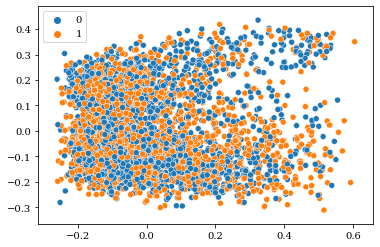

In [ ]:
sn.scatterplot(pca_trasnformed[:,0], pca_trasnformed[:,1], hue = Y_test)

In [53]:
def plot_pca(X,y, title, fname, method = "pca"):
    import matplotlib.pyplot as plt
    plt.rcParams['font.family'] = 'Serif'

    if method == "pca":
        pca = PCA(n_components=2)
        M=6000
    elif method == "tsne":
        pca = TSNE(n_components=2, learning_rate="auto", init="pca")
        M=2000
        
    X_proj = pca.fit_transform(X[:M])
    ax = plt.axes()
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='gray', linestyle='dashed')
    ax.xaxis.grid(color='gray', linestyle='dashed')
    
    y_text = ["Female-biased" if yy==1 else "Male-biased" for yy in y]
    plt1 = sn.scatterplot(X_proj[:, 0], X_proj[:, 1], hue = y_text[:M])
    plt.legend(fontsize=19)
    ax.set_title('{}'.format(title), fontsize=25)
    ax.figure.savefig("{}.pdf".format(fname), dpi = 400)
    plt.show()
    plt.clf()
    

In [ ]:
#plot_pca(X_test, Y_test, "Original Space", "kernel-original")

: 

/home/nlp/ravfogs/anaconda3/envs/py3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


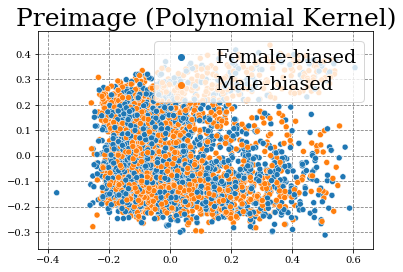

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_pca(pca_trasnformed, Y_test, "Preimage (Polynomial Kernel)", "kernel-transformed")

### WEAT

In [55]:
# Auxiliary functions for experiments by Caliskan et al.

import scipy
import scipy.misc as misc
import itertools

from sklearn.metrics.pairwise import cosine_similarity

def get_sim(vecs, w2ind, w1, w2):
    v1,v2 = vecs[w2ind[w1]], vecs[w2ind[w2]]
    sim = cosine_similarity([v1],[v2])[0]
    return sim
    

def s_word(w, A, B, vecs, w2ind, all_s_words):
    
    if w in all_s_words:
        return all_s_words[w]
    
    mean_a = []
    mean_b = []
    
    for a in A:
        mean_a.append(get_sim(vecs, w2ind, w, a))# model.similarity(w,a))
    for b in B:
        mean_b.append(get_sim(vecs, w2ind, w, b)) # model.similarity(w,b))
        
    mean_a = sum(mean_a)/float(len(mean_a))
    mean_b = sum(mean_b)/float(len(mean_b))
    
    all_s_words[w] = mean_a - mean_b

    return all_s_words[w]


def s_group(X, Y, A, B, vecs, w2ind, all_s_words):
    
    total = 0
    total_x, total_y = 0.,0.
    all_vals = []
    
    for x in X:
        x_sim = s_word(x, A, B, vecs, w2ind, all_s_words)
        total += x_sim
        total_x += x_sim
        all_vals.append(x_sim)
    for y in Y:
        y_sim =  s_word(y, A, B, vecs, w2ind, all_s_words)
        total -= y_sim
        total_y += y_sim
        all_vals.append(y_sim)
    
    #print(x_sim, y_sim)
    numerator = total_x/len(X) - total_y/len(Y)
    
    return total,numerator/np.std(all_vals)


def p_value_exhust(X, Y, A, B, vecs, w2ind):
    ["Ps"]
    if len(X) > 10:
        print ('might take too long, use sampled version: p_value')
        return
    
    assert(len(X) == len(Y))
    
    all_s_words = {}
    s_orig,d_statistic = s_group(X, Y, A, B, vecs, w2ind, all_s_words)
    #print("s-orig: {}".format(s_orig))
    
    union = set(X+Y)
    subset_size = int(len(union)/2)
    
    larger = 0
    total = 0
    #all_subs = set(itertools.combinations(union, subset_size))
    #print(all_subs)
    s_group_vals = []
    
    for subset in set(itertools.combinations(union, subset_size)):
        total += 1
        Xi = list(set(subset))
        Yi = list(union - set(subset))
        
        
        val,_ = s_group(Xi, Yi, A, B, vecs, w2ind, all_s_words)
        s_group_vals.append(val)
        
        if val > s_orig:
            larger += 1
    #print ('num of samples', total)
    
    return larger/float(total), d_statistic


def p_value_sample(X, Y, A, B, vecs, w2ind):
    
    random.seed(10)
    np.random.seed(10)
    all_s_words = {}
    
    assert(len(X) == len(Y))
    length = len(X)
    
    s_orig,_ = s_group(X, Y, A, B, vecs, w2ind, all_s_words) 
    
    num_of_samples = min(10000, int(scipy.special.comb(length*2,length)*100))
    print ('num of samples', num_of_samples)
    larger = 0
    for i in range(num_of_samples):
        permute = np.random.permutation(X+Y)
        Xi = permute[:length]
        Yi = permute[length:]
        if s_group(Xi, Yi, A, B, vecs, w2ind, all_s_words) > s_orig:
            larger += 1
    
    return larger/float(num_of_samples)

In [56]:
A = ['john', 'paul', 'mike', 'kevin', 'steve', 'greg', 'jeff', 'bill']
B = ['amy', 'joan', 'lisa', 'sarah', 'diana', 'kate', 'ann', 'donna']

C = ['executive', 'management', 'professional', 'corporation', 'salary', 'office', 'business', 'career']
D = ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding', 'relatives']
E = ['math', 'algebra', 'geometry', 'calculus', 'equations', 'computation', 'numbers', 'addition']
FF = ['poetry', 'art', 'dance', 'literature', 'novel', 'symphony', 'drama', 'sculpture']
G = ['science', 'technology', 'physics', 'chemistry', 'einstein', 'nasa', 'experiment', 'astronomy']
H = ['poetry', 'art', 'shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']

words_all_weat = set(A+B+C+D+E+FF+G+H)
vecs_all_weat = np.array([model_all[w] for w in words_all_weat])
w2ind = {w:i for i,w in enumerate(words_all_weat)}
vecs_all_weat = np.concatenate([vecs_all_weat, np.ones((len(vecs_all_weat), 1))], axis=1)
vecs_all_weat=vecs_all_weat/np.linalg.norm(vecs_all_weat, axis=1, keepdims=True)

In [57]:
alpha="0.8"
gamma="0.15"
degree="3"
kernel="poly"

weat = []

for seed in [10,11,12,13]:
    ds, ps = [], []
    with open("interim/glove{}/kernel/preimage/MLP.kernel-type={}_d=1024_gamma={}_degree={}_alpha={}.pickle".format(
        seed, kernel, gamma, degree, alpha), "rb") as f:
        mlp, _, _ = pickle.load(f)
        vecs_weat_transformed = mlp(torch.tensor(vecs_all_weat).float()).detach().cpu().numpy()
        p,d = p_value_exhust(A, B, C, D, vecs_weat_transformed, w2ind)
        d = d.item()
        ds.append(d)
        ps.append(p)
    
    weat.append({"d": np.mean(ds), "p": np.mean(ps)})

In [64]:
def calc_weat(average_over_kernels=True, mode="art-science"):


    weat = []
    if mode == "art-science":
        X,Y = G,H
    elif mode == "family-career":
        X,Y = C,D
    elif mode == "math-art":
        X,Y = E,FF

    for filename in tqdm.tqdm(os.listdir("./interim/glove{}/kernel/preimage".format(run_id))):
        
        
        if not filename.endswith(".pickle"): continue
        if not "Z." in filename: continue
            
        params_str = (filename.rsplit('.', 1)[0]).split('.', 1)[1]
        params_dict = {kv.split("=")[0]:kv.split("=")[1] for kv in params_str.split("_")}
        #print(params_dict)
        
        kernel,gamma,alpha,degree=params_dict["kernel-type"], params_dict["gamma"], params_dict["alpha"],params_dict["degree"]
        
        ds, ps = [], []
        for seed in [10,11,12,13]:
                  
            with open("interim/glove{}/kernel/preimage/MLP.kernel-type={}_d=1024_gamma={}_degree={}_alpha={}.pickle".format(
                seed, kernel, gamma, degree, alpha), "rb") as f:
                mlp, _, _ = pickle.load(f)
                vecs_weat_transformed = mlp(torch.tensor(vecs_all_weat).float()).detach().cpu().numpy()
                p,d = p_value_exhust(A, B, G,H, vecs_weat_transformed, w2ind)
                d = d.item()
                ds.append(d)
                ps.append(p)
    
        mean,std = np.mean(ds), np.std(ds)
        d_str = "{:.2f} $\pm$ {:.2f}".format(mean, std)
        
        mean,std = np.mean(ps), np.std(ps)
        p_str = "{:.3f} $\pm$ {:.3f}".format(mean, std)
        
        weat.append({"Kernel": kernel, "gamma": gamma, "alpha": alpha, "deg": degree, "d": d_str, "p": p_str, "d_raw": np.mean(ds), "p_raw": np.mean(ps)})

    if average_over_kernels:
        weat_new = []
        kernels = set([w["Kernel"] for w in weat])
        for kernel in kernels:
            mean_d = np.mean([w["d_raw"] for w in weat if w["Kernel"]==kernel])
            mean_p = np.mean([w["p_raw"] for w in weat if w["Kernel"]==kernel])
            std_d = np.std([w["d_raw"] for w in weat if w["Kernel"]==kernel])
            std_p = np.std([w["p_raw"] for w in weat if w["Kernel"]==kernel])
            p_str = "{:.2f} $\pm$ {:.2f}".format(mean_p, std_p)
            d_str = "{:.2f} $\pm$ {:.2f}".format(mean_d, std_d)
            weat_new.append({"Kernel": kernel, "d": d_str, "p": p_str})
        weat = weat_new
    return weat

In [65]:
# weat_clean = []
# for q in weat:
#     if "Kernel" not in q: continue
#     if q["Kernel"] != "UniformMK-RBF":
#         weat_clean.append(q)
weat_clean_avg = calc_weat(average_over_kernels=True, mode="science-art")
weat_art_science_avg = pd.DataFrame(weat_clean_avg)

weat_clean = calc_weat(average_over_kernels=False, mode="science-art")
weat_art_science = pd.DataFrame(weat_clean)

100%|██████████| 129/129 [02:37<00:00,  1.22s/it]


In [67]:
weat_art_science_avg

,Kernel,d,p
0,EasyMKL,0.73 $\pm$ 0.00,0.08 $\pm$ 0.00
1,poly,0.74 $\pm$ 0.01,0.08 $\pm$ 0.00
2,UniformMK,0.73 $\pm$ 0.00,0.08 $\pm$ 0.00
3,rbf,0.74 $\pm$ 0.00,0.08 $\pm$ 0.00
4,linear,0.74 $\pm$ 0.00,0.08 $\pm$ 0.00
5,laplace,0.71 $\pm$ 0.03,0.09 $\pm$ 0.01
6,UniformMK-RBF,0.74 $\pm$ 0.00,0.08 $\pm$ 0.00
7,sigmoid,0.75 $\pm$ 0.02,0.08 $\pm$ 0.01


In [66]:
with pd.option_context("max_colwidth", 1000):
    
    weat_art_science_avg.to_latex(buf="out-kernels/table-weat-art-science-avg.latex", encoding='utf-8',escape=False,index=False)
    weat_art_science.to_latex(buf="out-kernels/table-weat-art-science.latex", encoding='utf-8',escape=False,index=False)

/tmp/ipykernel_3405/3053714021.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  weat_art_science_avg.to_latex(buf="out-kernels/table-weat-art-science-avg.latex", encoding='utf-8',escape=False,index=False)
/tmp/ipykernel_3405/3053714021.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  weat_art_science.to_latex(buf="out-kernels/table-weat-art-science.latex", encoding='utf-8',escape=False,index=False)


In [100]:
df_all_avg

,Kernel,d,p,Accuracy
0,EasyMKL,0.73 $\pm$ 0.00,0.08 $\pm$ 0.00,0.59 $\pm$ 0.15
1,poly,0.74 $\pm$ 0.01,0.08 $\pm$ 0.00,0.69 $\pm$ 0.16
2,UniformMK,0.73 $\pm$ 0.00,0.08 $\pm$ 0.00,0.75 $\pm$ 0.11
3,rbf,0.74 $\pm$ 0.00,0.08 $\pm$ 0.00,0.54 $\pm$ 0.02
4,linear,0.74 $\pm$ 0.00,0.08 $\pm$ 0.00,0.49 $\pm$ 0.00
5,laplace,0.71 $\pm$ 0.03,0.09 $\pm$ 0.01,0.69 $\pm$ 0.01
6,sigmoid,0.75 $\pm$ 0.02,0.08 $\pm$ 0.01,0.49 $\pm$ 0.00


In [99]:
df_accs = pd.read_csv("out-kernels/kernels-acc-preimage-same-cr.csv")
df_accs_avg = pd.read_csv("out-kernels/kernels-acc-preimage-same-avg-cr.csv")
accs_dict = df_accs.to_dict("records")
accs_dict_avg = df_accs_avg.to_dict("records")

for i, (d,d2) in enumerate(zip(accs_dict, weat_clean)):
    weat_clean[i]["Accuracy"] = d["Accuarcy"]
df_all = pd.DataFrame(weat_clean)

weat_clean_avg = [d for d in weat_clean_avg if d["Kernel"] != "UniformMK-RBF"] # remove irrelevant kernel
for i, (d,d2) in enumerate(zip(accs_dict_avg, weat_clean_avg)):
    weat_clean_avg[i]["Accuracy"] = d["Accuracy"]
df_all_avg = pd.DataFrame(weat_clean_avg)

with pd.option_context("max_colwidth", 1000):
    
    df_all.to_latex(buf="out-kernels/table-weat-art-science-and-accuracies-on-preimage.latex", encoding='utf-8',escape=False,index=False)
    df_all_avg.to_latex(buf="out-kernels/table-weat-art-science-and-accuracies-on-preimage-avg.latex", encoding='utf-8',escape=False,index=False)

/tmp/ipykernel_3405/798206068.py:17: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_all.to_latex(buf="out-kernels/table-weat-art-science-and-accuracies-on-preimage.latex", encoding='utf-8',escape=False,index=False)
/tmp/ipykernel_3405/798206068.py:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_all_avg.to_latex(buf="out-kernels/table-weat-art-science-and-accuracies-on-preimage-avg.latex", encoding='utf-8',escape=False,index=False)


In [70]:
df_accs

,Unnamed: 0,type,gamma,deg,alpha,Accuarcy
0,0,poly,0.05,2,0.8,0.49 $\pm$ 0.00
1,1,poly,0.05,2,1,0.49 $\pm$ 0.00
2,2,poly,0.05,2,1.2,0.49 $\pm$ 0.00
3,3,poly,0.05,3,0.8,0.49 $\pm$ 0.00
4,4,poly,0.05,3,1,0.49 $\pm$ 0.00
5,5,poly,0.05,3,1.2,0.49 $\pm$ 0.00
6,6,poly,0.1,2,0.8,0.49 $\pm$ 0.00
7,7,poly,0.1,2,1,0.49 $\pm$ 0.00
8,8,poly,0.1,2,1.2,0.49 $\pm$ 0.00
9,9,poly,0.1,3,0.8,0.53 $\pm$ 0.01
